In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
from functools import reduce

In [2]:

# Define the ticker symbols
tickers = {
    'BTC-USD': 'BTC',
    '^TNX': 'RF',
    'SPY': 'SPY',
    '^VIX': 'VIX'
}

# Define the date range
start_date = pd.to_datetime('2019-11-01')
end_date = pd.to_datetime('2024-10-31')

# Initialize an empty dictionary to store DataFrames
data_frames = {}

# Loop through each ticker and download the data
for ticker, name in tickers.items():
    # Download the data
    data = yf.download(ticker, start=start_date-timedelta(days=300), end=end_date)
    
    # Reset index to make 'Date' a column
    data = data.reset_index()
    
    # Convert 'Date' to datetime.date format
    data['date'] = pd.to_datetime(data['Date']).dt.date
    
    # Select relevant columns and rename them
    if ticker == 'BTC-USD':
        # For Bitcoin, keep 'Close' and 'Volume'
        data = data[['date', 'Close', 'Volume']]
        data.rename(columns={'Close': 'PRC', 'Volume': 'Vol'}, inplace=True)
    elif ticker == '^TNX':
        # For 10-year Treasury Yield, keep 'Close' and adjust yield to percentage
        data = data[['date', 'Close']]
        data.rename(columns={'Close': 'RF'}, inplace=True)
        # Convert yield from percentage points to decimal (e.g., 15.00 to 0.15)
        data['RF'] = data['RF'] / 100
    else:
        # For SPY and VIX, keep 'Adj Close'
        data = data[['date', 'Adj Close']]
        data.rename(columns={'Adj Close': name}, inplace=True)
    
    # Store the DataFrame in the dictionary
    data_frames[name] = data

# Merge all DataFrames on 'date'

dfs = list(data_frames.values())
merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
merged_data.columns = merged_data.columns.get_level_values(0) 
merged_data['Chg'] = merged_data['PRC']/merged_data['PRC'].shift()-1

merged_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_2478/2309497488.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_2478/2309497488.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_2478/2309497488.py:49: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), 

Price,date,PRC,Vol,RF,SPY,VIX,Chg
0,2019-01-07,4025.248291,5228625637,0.02682,232.238068,21.400000,NaN
1,2019-01-08,4030.847900,5306593305,0.02716,234.419998,20.469999,0.001391
2,2019-01-09,4035.296387,5115905225,0.02728,235.515594,19.980000,0.001104
3,2019-01-10,3678.924561,6874143796,0.02731,236.346313,19.500000,-0.088314
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001,0.002294
...,...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235


In [3]:
# create the signal for the trading range breakout
merged_data['SUP_50'] = merged_data['PRC'].shift(1).rolling(window=50).min()
merged_data['RES_50'] = merged_data['PRC'].shift(1).rolling(window=50).max()
merged_data['SUP_150'] = merged_data['PRC'].shift(1).rolling(window=150).min()
merged_data['RES_150'] = merged_data['PRC'].shift(1).rolling(window=150).max()
merged_data['SUP_200'] = merged_data['PRC'].shift(1).rolling(window=200).min()
merged_data['RES_200'] = merged_data['PRC'].shift(1).rolling(window=200).max()
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP_50,RES_50,SUP_150,RES_150,SUP_200,RES_200
0,2019-01-07,4025.248291,5228625637,0.02682,232.238068,21.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-08,4030.847900,5306593305,0.02716,234.419998,20.469999,0.001391,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-09,4035.296387,5115905225,0.02728,235.515594,19.980000,0.001104,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-10,3678.924561,6874143796,0.02731,236.346313,19.500000,-0.088314,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001,0.002294,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,69907.757812,53948.753906,71631.359375,39507.367188,73083.5


In [4]:
a=12
b=26
c=9

merged_data['EMA_a'] = merged_data['PRC'].ewm(span=a, adjust=False).mean()
merged_data['EMA_b'] = merged_data['PRC'].ewm(span=b, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_a'] - merged_data['EMA_b']
merged_data['MACD_Sig'] = merged_data['MACD'].ewm(span=c, adjust=False).mean()
merged_data['MACD_Hist'] = merged_data['MACD'] - merged_data['MACD_Sig']
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP_50,RES_50,SUP_150,RES_150,SUP_200,RES_200,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist
0,2019-01-07,4025.248291,5228625637,0.02682,232.238068,21.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4025.248291,4025.248291,0.000000,0.000000,0.000000
1,2019-01-08,4030.847900,5306593305,0.02716,234.419998,20.469999,0.001391,NaN,NaN,NaN,NaN,NaN,NaN,4026.109769,4025.663077,0.446692,0.089338,0.357354
2,2019-01-09,4035.296387,5115905225,0.02728,235.515594,19.980000,0.001104,NaN,NaN,NaN,NaN,NaN,NaN,4027.523095,4026.376655,1.146440,0.300759,0.845681
3,2019-01-10,3678.924561,6874143796,0.02731,236.346313,19.500000,-0.088314,NaN,NaN,NaN,NaN,NaN,NaN,3973.892551,4000.639463,-26.746912,-5.108775,-21.638136
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001,0.002294,NaN,NaN,NaN,NaN,NaN,NaN,3929.811463,3977.433983,-47.622520,-13.611524,-34.010995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5,66139.387225,64391.208851,1748.178373,1436.399029,311.779345
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5,66216.775969,64557.964793,1658.811176,1480.881458,177.929718
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.5,66784.619329,64954.245757,1830.373572,1550.779881,279.593691
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,69907.757812,53948.753906,71631.359375,39507.367188,73083.5,67697.830538,65529.523271,2168.307268,1674.285358,494.021909


In [5]:
merged_data = merged_data.dropna()
merged_data = merged_data[(merged_data['date'] >= pd.to_datetime(start_date).date()) & (merged_data['date'] <= pd.to_datetime(end_date).date())]
merged_data = merged_data.reset_index(drop=True)

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP_50,RES_50,SUP_150,RES_150,SUP_200,RES_200,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,0.006687,7493.488770,10623.540039,4158.183105,13016.231445,3399.471680,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813
1,2019-11-04,9412.612305,26170255634,0.01786,284.530457,12.830000,0.016360,7493.488770,10623.540039,4879.877930,13016.231445,3399.471680,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505
2,2019-11-05,9342.527344,26198609048,0.01866,284.215668,13.100000,-0.007446,7493.488770,10623.540039,4922.798828,13016.231445,3399.471680,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,0.001964,7493.488770,10623.540039,4922.798828,13016.231445,3399.471680,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821
4,2019-11-07,9267.561523,22700383839,0.01926,285.280182,12.730000,-0.009969,7493.488770,10623.540039,5036.681152,13016.231445,3399.471680,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.500000,66139.387225,64391.208851,1748.178373,1436.399029,311.779345
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.500000,66216.775969,64557.964793,1658.811176,1480.881458,177.929718
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,68418.789062,53948.753906,71631.359375,39507.367188,73083.500000,66784.619329,64954.245757,1830.373572,1550.779881,279.593691
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,69907.757812,53948.753906,71631.359375,39507.367188,73083.500000,67697.830538,65529.523271,2168.307268,1674.285358,494.021909


In [6]:
merged_data['sig_1'] = np.where(merged_data['PRC'] > merged_data['RES_150'], 1, 0)  # Buy signal
merged_data['sig_1'] = np.where(merged_data['PRC'] < merged_data['SUP_150'], -1, merged_data['sig_1'])  # Sell signal

merged_data['sig_50'] = np.where(merged_data['PRC'] > merged_data['RES_50'], 1, 0)  # Buy signal
merged_data['sig_50'] = np.where(merged_data['PRC'] < merged_data['SUP_50'], -1, merged_data['sig_50'])  # Sell signal

merged_data['sig_200'] = np.where(merged_data['PRC'] > merged_data['RES_200'], 1, 0)  # Buy signal
merged_data['sig_200'] = np.where(merged_data['PRC'] < merged_data['SUP_200'], -1, merged_data['sig_200'])  # Sell signal

merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] > 15) & (merged_data['MACD_Hist'].shift() < 15), 1, 0)  # Buy signal
merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] < -15) & (merged_data['MACD_Hist'].shift() > -15), -1, merged_data['sig_2'])  # Sell signal

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP_50,RES_50,SUP_150,...,RES_200,EMA_a,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_50,sig_200,sig_2
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,0.006687,7493.488770,10623.540039,4158.183105,...,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813,0,0,0,0
1,2019-11-04,9412.612305,26170255634,0.01786,284.530457,12.830000,0.016360,7493.488770,10623.540039,4879.877930,...,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505,0,0,0,0
2,2019-11-05,9342.527344,26198609048,0.01866,284.215668,13.100000,-0.007446,7493.488770,10623.540039,4922.798828,...,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847,0,0,0,0
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,0.001964,7493.488770,10623.540039,4922.798828,...,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821,0,0,0,0
4,2019-11-07,9267.561523,22700383839,0.01926,285.280182,12.730000,-0.009969,7493.488770,10623.540039,5036.681152,...,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,68418.789062,53948.753906,...,73083.500000,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,0
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,68418.789062,53948.753906,...,73083.500000,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,0
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,68418.789062,53948.753906,...,73083.500000,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,1,0,0
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,69907.757812,53948.753906,...,73083.500000,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,1,0,0


In [7]:
def calculate_sig3(row):
    if row['sig_1'] == 0:
        return row['sig_2']
    elif row['sig_1'] == -1* row['sig_2']:
        return 0
    else:
        return row['sig_1']

# Apply the function row-wise
merged_data['sig_3'] = merged_data.apply(calculate_sig3, axis=1)

In [8]:
def test_fcn(data, cb, cs, sig_name):
    T = len(data)
    nUSD = 1.0
    nBTC = 0.0
    CR = [1.0]

    # Trading simulation loop
    for t in range(T - 1):
        # Get the signal for the current time step
        signal = data.loc[t, sig_name]
        price_t = data.loc[t, 'PRC']
        price_t1 = data.loc[t + 1, 'PRC']
    
        if signal == 1 and nBTC == 0:  # Buy condition
            nBTC = nUSD * (1 - cb) / price_t
            nUSD = 0
        elif signal == -1 and nBTC > 0:  # Sell condition
            nUSD = nBTC * (1 - cs) * price_t
            nBTC = 0
        # elif signal == -1 and nBTC == 0:  # Short condition
        # nBTCb = nUSD / price_t
        # nUSD = nUSD + nBTCb * (1 - cs) * price_t - nBTCb * price_t1 / (1 - cb)
    
        # Update cumulative return
        CR.append(nUSD + nBTC * price_t1 * (1 - cs))

    # Save cumulative return to the data frame
    data['cumulative_return'] = CR

    return data

In [9]:
# testing

BreakOut = test_fcn(merged_data, 0.001, 0.001, 'sig_1').copy()
MACD = test_fcn(merged_data, 0.001, 0.001, 'sig_2').copy()
Combined = test_fcn(merged_data, 0.001, 0.001, 'sig_3').copy()


In [10]:
B_50 = test_fcn(merged_data, 0.001, 0.001, 'sig_50').copy()
B_150 = test_fcn(merged_data, 0.001, 0.001, 'sig_1').copy()
B_200 = test_fcn(merged_data, 0.001, 0.001, 'sig_200').copy()

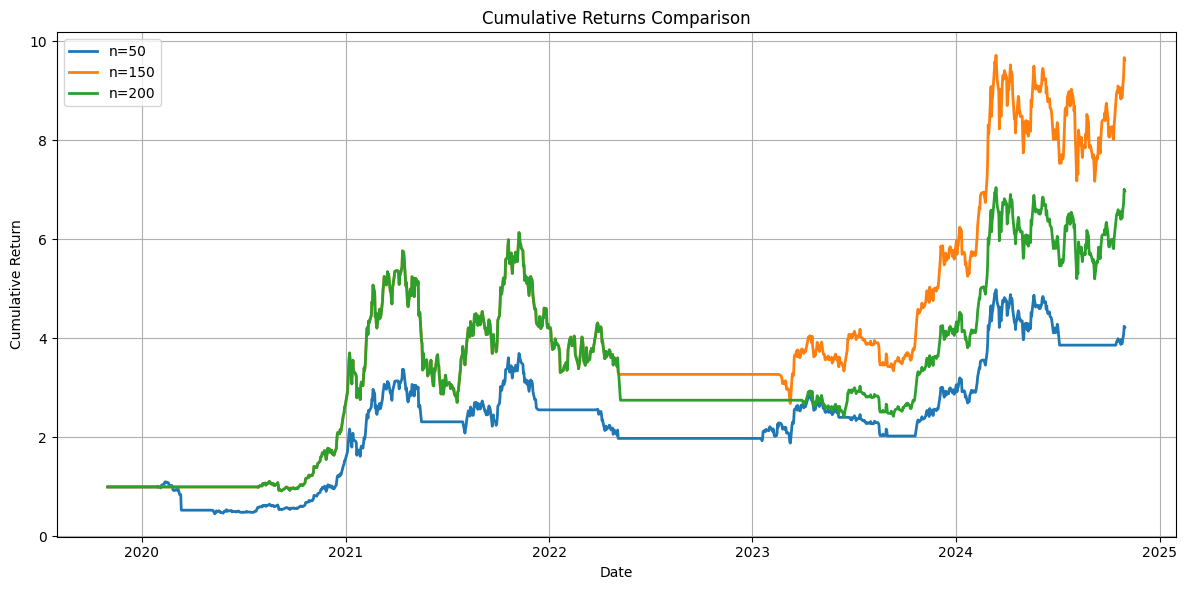

In [11]:
B_50 = B_50.sort_values(by='date')
B_150 = B_150.sort_values(by='date')
B_200 = B_200.sort_values(by='date')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(B_50['date'], B_50['cumulative_return'], label='n=50', linewidth=2)
plt.plot(B_150['date'], B_150['cumulative_return'], label='n=150', linewidth=2)
plt.plot(B_200['date'], B_200['cumulative_return'], label='n=200', linewidth=2)

# Chart details
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

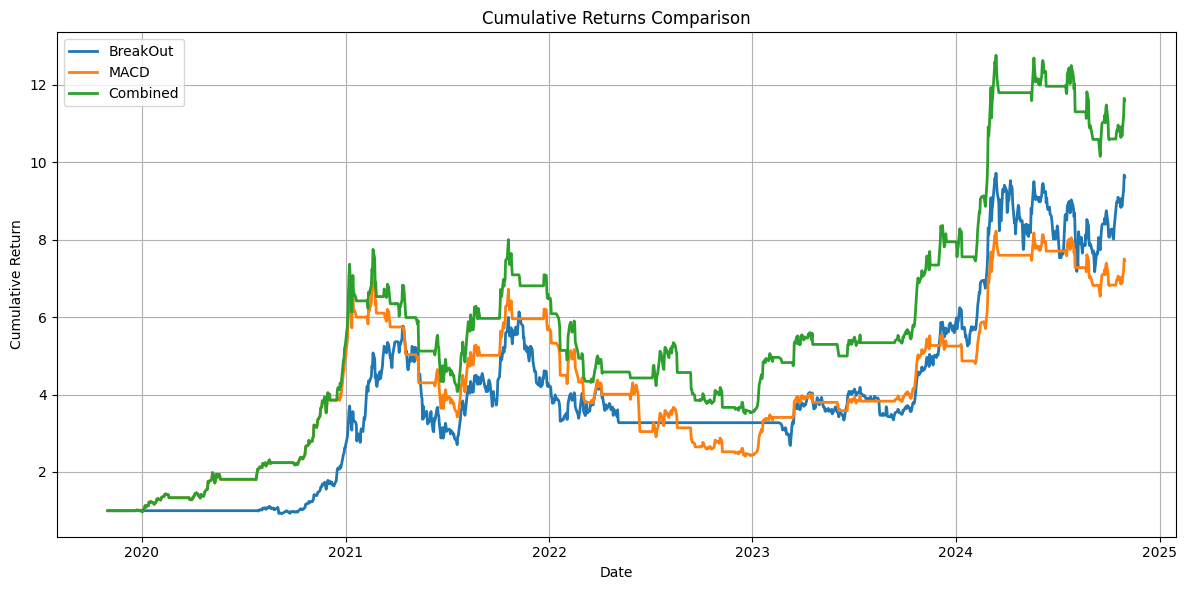

In [12]:
BreakOut = BreakOut.sort_values(by='date')
MACD = MACD.sort_values(by='date')
Combined = Combined.sort_values(by='date')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(BreakOut['date'], BreakOut['cumulative_return'], label='BreakOut', linewidth=2)
plt.plot(MACD['date'], MACD['cumulative_return'], label='MACD', linewidth=2)
plt.plot(Combined['date'], Combined['cumulative_return'], label='Combined', linewidth=2)

# Chart details
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
# sharpe ratio
def calSharpe(data):    
    data['daily_return'] = data['cumulative_return'].pct_change()
    data['excess_return'] = data['daily_return'] - (data['RF'] / 252)

    # Calculate the mean and standard deviation of excess returns
    mean_excess_return = data['excess_return'].mean()
    std_excess_return = data['excess_return'].std()

    # Calculate Sharpe Ratio
    sharpe_ratio = mean_excess_return / std_excess_return
    return sharpe_ratio

In [14]:
print(f"{'Sharpe Ratio - Breakout:':<30} {calSharpe(BreakOut):>10.4f}")
print(f"{'Sharpe Ratio - MACD:':<30} {calSharpe(MACD):>10.4f}")
print(f"{'Sharpe Ratio - Combined:':<30} {calSharpe(Combined):>10.4f}")


Sharpe Ratio - Breakout:           0.0683
Sharpe Ratio - MACD:               0.0687
Sharpe Ratio - Combined:           0.0828


In [15]:
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,Chg,SUP_50,RES_50,SUP_150,...,EMA_b,MACD,MACD_Sig,MACD_Hist,sig_1,sig_50,sig_200,sig_2,sig_3,cumulative_return
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,0.006687,7493.488770,10623.540039,4158.183105,...,8743.600599,31.690016,-175.913797,207.603813,0,0,0,0,0,1.000000
1,2019-11-04,9412.612305,26170255634,0.01786,284.530457,12.830000,0.016360,7493.488770,10623.540039,4879.877930,...,8793.157021,80.183084,-124.694421,204.877505,0,0,0,0,0,1.000000
2,2019-11-05,9342.527344,26198609048,0.01866,284.215668,13.100000,-0.007446,7493.488770,10623.540039,4922.798828,...,8833.851119,111.671638,-77.421209,189.092847,0,0,0,0,0,1.000000
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,0.001964,7493.488770,10623.540039,4922.798828,...,8872.890287,136.533567,-34.630254,171.163821,0,0,0,0,0,1.000000
4,2019-11-07,9267.561523,22700383839,0.01926,285.280182,12.730000,-0.009969,7493.488770,10623.540039,5036.681152,...,8902.125193,147.012148,1.698226,145.313922,0,0,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,0.026024,53948.753906,68418.789062,53948.753906,...,64391.208851,1748.178373,1436.399029,311.779345,0,0,0,0,0,6.571252
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,-0.022280,53948.753906,68418.789062,53948.753906,...,64557.964793,1658.811176,1480.881458,177.929718,0,0,0,0,0,6.424844
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,0.048998,53948.753906,68418.789062,53948.753906,...,64954.245757,1830.373572,1550.779881,279.593691,0,1,0,0,0,6.739648
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,0.040235,53948.753906,69907.757812,53948.753906,...,65529.523271,2168.307268,1674.285358,494.021909,1,1,0,0,1,7.010817


In [16]:
print(f"{'SPY:':<15} {merged_data.iloc[-1]['SPY'] / merged_data.iloc[0]['SPY']:>10.4f}")
print(f"{'Buy and Hold:':<15} {merged_data.iloc[-1]['PRC'] / merged_data.iloc[0]['PRC']:>10.4f}")
print(f"{'Breakout:':<15} {BreakOut.iloc[-1]['cumulative_return']:>10.4f}")
print(f"{'MACD:':<15} {MACD.iloc[-1]['cumulative_return']:>10.4f}")
print(f"{'Combined:':<15} {Combined.iloc[-1]['cumulative_return']:>10.4f}")

SPY:                2.0467
Buy and Hold:       7.8111
Breakout:           9.6178
MACD:               7.4628
Combined:          11.5871


[]

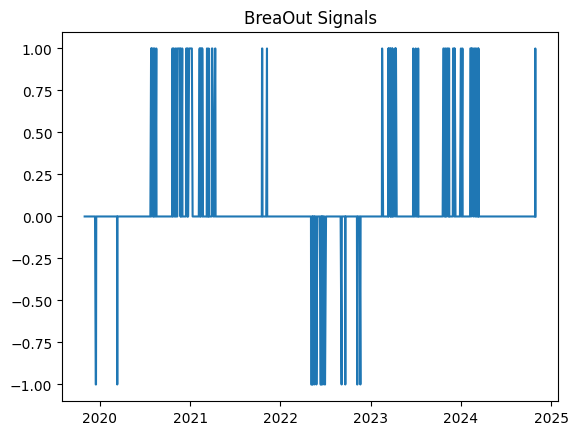

In [22]:
plt.plot(merged_data['date'], merged_data['sig_1'], label='BreakOut', linestyle='-')
plt.title('BreaOut Signals')
plt.plot()

[]

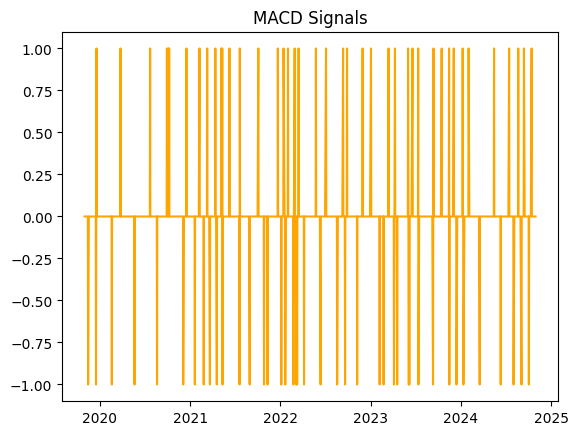

In [23]:
plt.plot(merged_data['date'], merged_data['sig_2'], label='BreakOut', color='orange', linestyle='-')
plt.title('MACD Signals')
plt.plot()

<Axes: >

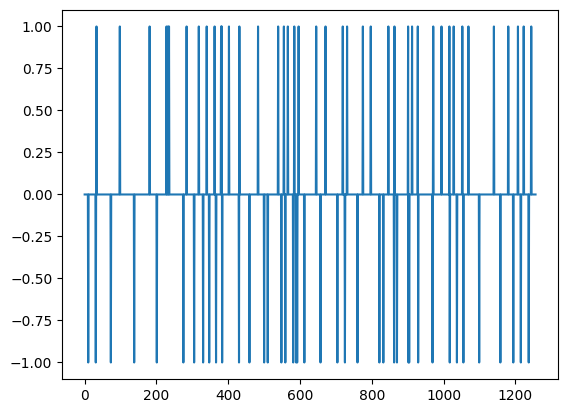

In [18]:
merged_data['sig_2'].plot()